In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sentence_transformers import SentenceTransformer
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.pyplot import figure
import os
import warnings
warnings.filterwarnings("ignore")


In [ ]:
generate_plots = False ### Time estimate: 15 minutes




In [2]:
full_data = pd.read_csv("data/processed_data/cleaned_v1.csv")
embeddings = torch.load('corpus_embeddings_bi_encoder.pt')

print(full_data.columns)

Loading full data
Loading model
Index(['id', 'country', 'name', 'NACE', 'description',
       'description_no_stopwords', 'description_no_stopwords_stemmed'],
      dtype='object')


In [3]:
def firmnav_id_toIndex(firmnav_id):
    return full_data.index[full_data['id'] == firmnav_id].tolist()

def firmnav_index_toEmbedding(firmnav_index):
    return embeddings[firmnav_index]

def firmnav_idArray_toIndexArray(idArray):
    newArray = [firmnav_id_toIndex(id) for id in idArray]
    return newArray

def decrease_array_depth(array):
    newArray = []
    for item in array:
        if not item == []:
            newArray += [item[0]]
    return newArray


In [4]:
def getIndexArrays(file_path, separator=';'):
    df = pd.read_csv(file_path, sep=separator)

    pos_init = df.loc[df['Rating'] == 1.0].loc[df['AI search'] == 'Initial']['Firmnav ID']
    pos_res = df.loc[df['Rating'] == 1.0][df['AI search'].isna()]['Firmnav ID']
    neg_res = df.loc[df['Rating'] == 0.0][df['AI search'].isna()]['Firmnav ID']

    init_i = decrease_array_depth(firmnav_idArray_toIndexArray(pos_init))
    pos_i = decrease_array_depth(firmnav_idArray_toIndexArray(pos_res))
    neg_i = decrease_array_depth(firmnav_idArray_toIndexArray(neg_res))

    return init_i, pos_i, neg_i

In [5]:
principal_components_k = 50

pca_model = PCA(n_components=principal_components_k)
principal_components_train = pca_model.fit_transform(embeddings)
transposed = np.array(principal_components_train).T
explained_variance = pca_model.explained_variance_ratio_

summ = explained_variance.sum()
cumsum = 0
total_var_explained = np.zeros(principal_components_k)
for i in range(principal_components_k):
    cumsum = cumsum + explained_variance[i]
    total_var_explained[i]=(cumsum/summ)




1.0


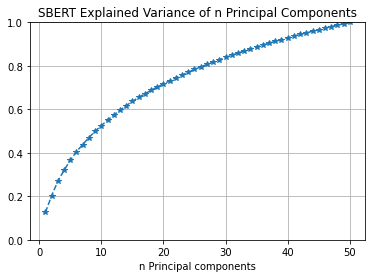

In [6]:
total_var_explained_trainPCA = np.array(total_var_explained)

print(total_var_explained[principal_components_k-1])
plt.plot(range(1,principal_components_k+1),total_var_explained,"--*")
plt.grid();
plt.title('SBERT Explained Variance of n Principal Components')
plt.xlabel('n Principal components')
plt.axis((None,None,0,1))
plt.show();

In [7]:
pop_a = mpatches.Patch(color='blue', label='initial')
pop_b = mpatches.Patch(color='green', label='positive')
pop_c = mpatches.Patch(color='red', label='negative')

In [8]:
print(len(full_data["description"]))
print(len(embeddings))

60122
60122


In [16]:
def plot_pca(filepath, title, component_a, component_b, n_other_samples, filename=False):
    figure(figsize=(5, 4), dpi=120)

    init_index_file, positive_index_file, negative_index_file = getIndexArrays(filepath)

    for x, y in zip(transposed[component_a,:n_other_samples], transposed[component_b,:n_other_samples]):
        plt.plot(x,y,".", color='black', alpha=0.1)

    for x, y in zip(transposed[component_a,negative_index_file], transposed[component_b,negative_index_file]):
        plt.plot(x,y,"v", color='red', alpha=0.6)

    for x, y in zip(transposed[component_a,positive_index_file], transposed[component_b,positive_index_file]):
        plt.plot(x,y,"^", color='green', alpha=0.6)

    for x, y in zip(transposed[component_a,init_index_file], transposed[component_b,init_index_file]):
        plt.plot(x,y,"s", color='blue', alpha=0.6)

    plt.legend(handles=[pop_a,pop_b, pop_c])
    plt.title(title)
    plt.xlabel(f'PC{component_a+1}')
    plt.ylabel(f'PC{component_b+1}')
    plt.xticks([], [])
    plt.yticks([], [])
    if filename:
        path = f'SBERT PCA figures/PC{component_a+1},PC{component_b+1}/{filename}.jpg'
        isExist = os.path.exists(f'SBERT PCA figures/PC{component_a+1},PC{component_b+1}')
        if not isExist:
            os.mkdir(f'SBERT PCA figures/PC{component_a+1},PC{component_b+1}')
        plt.savefig(f'SBERT PCA figures/PC{component_a+1},PC{component_b+1}/{filename}.jpg')
    else:
        plt.savefig(f'SBERT PCA figures/{title}.jpg')

    plt.close()

def plot_all_train(plots_per_file, n_other_samples):
    filenames = os.listdir('data/train')
    titles = [str.replace(".csv", "") for str in filenames]

    for i in range(len(filenames)):
        path = 'data/train/' + filenames[i]
        print(f"Plotting {titles[i]}...")
        for j in range(plots_per_file):
            c_a = j
            c_b = j+1

            fig_title = titles[i] + f' SBERT Embeddings: PC{j+1} vs PC{j+2}'
            filename = titles[i]

            plot_pca(path, fig_title, c_a, c_b, n_other_samples, filename)

if generate_plots:
    plot_all_train(4, 2500)
    print("DONE")

Plotting IT freelance...
Plotting PE fund...
Plotting M&A advisors...
Plotting IoT...
Plotting Procurement software...
Plotting Manufacturers...
Plotting Resource-efficiency...
Plotting Computer vision...
Plotting Industrial vertical investor...
Plotting Healthcare...
Plotting Online games...
Plotting Consulting...
Plotting Payments tech...
Plotting Fish processing equipment...
Plotting Innovative...
Plotting House builders...
Plotting Sustainability...
Plotting Fintech...
Plotting Wind turbine tech...
Plotting SaaS...
DONE


In [33]:
NACE_pca_colors = ['green', 'black', 'blue', 'red', 'orange', 'yellow', 'purple', 'brown', 'gray', 'pink']
#mpatches.Patch(color='blue', label='initial')

def firmnav_id_toNACE(firmnav_id):
    return int(full_data['NACE'][full_data["id"] == firmnav_id])

def firmnav_index_toNACE(firmnav_index):
    return int(full_data['NACE'].iloc[firmnav_index])

def plot_PCA_NACE(n_samples, component_a=0, component_b=1, title='SBERT PCA colored by NACE'):
    figure(figsize=(5, 4), dpi=120)

    for x, y in zip(transposed[component_a, :n_samples], transposed[component_b, :n_samples]):
        c = 'blue'
        plt.plot(x,y,".", color=c, alpha=0.1)

    populations = [mpatches.Patch(color=NACE_pca_colors[i], label=f'{i+1}') for i in range(len(NACE_pca_colors))]


    plt.legend(handles=populations)
    plt.title(title)
    plt.xlabel(f'PC{component_a+1}')
    plt.ylabel(f'PC{component_b+1}')
    plt.xticks([], [])
    plt.yticks([], [])
    plt.savefig(f'SBERT PCA figures/NACE PCA.jpg')

    plt.close()

#print(firmnav_id_toNACE('SE5592101991'))
#print(firmnav_id_toIndex('SE5560330788'))
#print(int(str(firmnav_index_toNACE(0))[0])-1)

ValueError: cannot convert float NaN to integer